In [ ]:
%pip install azure-ai-ml
%pip install -U 'azureml-rag[faiss]>=0.1.11'

In [ ]:
# If `import win32file` fails with a DLL error then run the following and restart kernel:
# %pip uninstall -y pywin32
# %conda install -y --force-reinstall pywin32

# Create a FAISS based Vector Index for DBCopilot with AzureML
We'll walk through setting up an AzureML Pipeline which grounding a DataBase into a LangChain-compatible FAISS Vector Index and create the promptflow to consume this index to serve as a DBCopilot chatbot.

## Get client for AzureML Workspace

The workspace is the top-level resource for Azure Machine Learning, providing a centralized place to work with all the artifacts you create when you use Azure Machine Learning. In this section we will connect to the workspace in which the job will be run.

Enter your Workspace details below, running this still will write a `workspace.json` file to the current folder.

In [ ]:
%%writefile workspace.json
{
    "subscription_id": "<subscription_id>",
    "resource_group": "<resource_group_name>",
    "workspace_name": "<workspace_name>"
}

`MLClient` is how you interact with AzureML

In [ ]:
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential
from azure.ai.ml import MLClient
from azureml.core import Workspace

try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    credential = InteractiveBrowserCredential()

try:
    ml_client = MLClient.from_config(credential=credential, path="workspace.json")
except Exception as ex:
    raise Exception(
        "Failed to create MLClient from config file. Please modify and then run the above cell with your AzureML Workspace details."
    ) from ex

ws = Workspace(
    subscription_id=ml_client.subscription_id,
    resource_group=ml_client.resource_group_name,
    workspace_name=ml_client.workspace_name,
)
print(ml_client)

## Create a Datastore
1. Go to workspace in Azure Portal
2. Click **Data** -> **Datastore** -> **+ Create**
3. Fill in the datastore form


### SQL Server Datastore
| Field | Value |
| --- | --- |
| Datastore name | the name for the datastore |
| Datastore type | Azure SQL Database |
| Account information| could be found in the Azure SQL Database overview page |
| Authentication type | SQL Authentication/ Service principal |
| Authentication info | SQL Authentication: username and password; Service principal: tenant id, client id, client secret |
### Kusto / Cosmos / ClickHouse Datastore
| Field | Value |
| --- | --- |
| Datastore name | the name for the datastore |
| Datastore type | Custom(preview) |
| Custom Datastore type | could fill in the custom type |
| Credential value | Datastore credential, an optional field that can be updated later.<br>Value will be stored securely in Azure Key Vault |
| Properties |Add any additional properties required for this datastore |
##### Additional properties required by Kusto / Cosmos / ClickHouse
<table>
    <tr>
        <td></td> 
        <td colspan="2"><b>Kusto</b></td> 
        <td colspan="2"><b>ClickHouse</b></td> 
        <td colspan="2"><b>Cosmos</b></td> 
   </tr>
    <tr>
        <td rowspan="6"><b>Required</b> <br/><b>properties</b></td>     
         <td>Property</td> 
      	 <td>Value</td> 
         <td>Property</td> 
      	 <td>Value</td> 
         <td>Property</td> 
      	 <td>Value</td> 
    </tr>
    <tr>
        <td>connection</td> 
        <td>connect to external data sources for training</td>
        <td>host</td>
        <td>host name or IP address of the ClickHouse database server</td>
        <td>url</td>
        <td>url of Azure Cosmos DB services</td>      
    </tr>
    <tr>
        <td>connection_string</td> 
        <td>the string that contains the information needed to connect <br>to an external data source for training</td>
        <td>user</td>
        <td>user name used to authenticate the database user for the connection</td>
        <td>key</td>
        <td> access key used for authorizing access and operations to <br>an Azure Cosmos DB account</td>      
    </tr>
    <tr>
        <td>database</td> 
        <td>database name</td>
        <td>port</td>
        <td>The port on which the ClickHouse server listens. By default, ClickHouse <br>uses port number 8123 as the client connection port</td>
        <td>container</td>
        <td>logical unit used to organize and store documents</td>      
    </tr>
    <tr>
        <td>tenant_id</td> 
        <td>unique identifier for your Azure Active Directory tenant</td>
        <td>password</td>
        <td>secret string that the user uses to verify their identity</td>
        <td>database</td>
        <td>database name</td>      
    </tr>
    <tr>
        <td>client_id</td> 
        <td>the identifier for a managed identity that is used to retrieve <br>a credential for accessing resources within the code for a <br>submitted job</td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>      
    </tr>
</table>

Use the datastore you created

In [ ]:
datastore_name = "<test_db_datastore_name>"
db_datastore_uri = f"azureml://datastores/{datastore_name}"

## Create a Data assets
1. Go to workspace in Azure Portal
2. Click **Data** -> **Data assets** -> **+ Create**
3. Fill in the Data assets form
### SQLite/Sheet Data assets
| Field | Value |
| --- | --- |
| Data assets name | the name for the Data assets |
| Data assets type | File(uri_file) / Folder(uri_folder) |
| Data source | From a URI / From Azure storage / From local files |

##### Different data source, Different parameters
<table>
    <tr> 
        <td colspan="2"><b>From a URL</b></td> 
        <td colspan="2"><b>From Azure storage</b></td> 
        <td colspan="2"><b>From local</b></td> 
   </tr>
    <tr>     
         <td>Field</td> 
      	 <td>Value</td> 
         <td>Field</td> 
      	 <td>Value</td> 
         <td>Field</td> 
      	 <td>Value</td> 
    </tr>
    <tr>
        <td>URI</td>
        <td>path parameter that points to the data location. Three formats are supported: <br>1. A path on a public http(s) server <br>2. A path on Azure storage<br>3. A path on a datastore</td>
        <td>Source storage type</td>
        <td>Azure Blob Storage / Azure file share / Azure Data Lake Storage Gen1 /<br> Azure Data Lake Storage Gen2</td>
        <td>Destination storage type</td> 
        <td>Azure Blob Storage / Azure Data Lake Storage Gen2</td>     
    </tr>
    <tr>
        <td></td>
        <td></td>
        <td>Storage path</td>
        <td>storage path you want to use for this data asset</td>
        <td>File selection</td>
        <td>Upload file</td>     
    </tr>

</table>


<H3>Example for Tabular Data</H3>

In [ ]:
%pip install pandas
%pip install -U mltable azureml-dataprep[pandas]

In [ ]:
%%writefile test.csv
id,text
0,Hello world!

In [ ]:
import sqlite3
import mltable
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes

tbl = mltable.from_delimited_files([{"file": "test.csv"}])
# Convert tabular data to sqlite db
df = tbl.to_pandas_dataframe()
conn = sqlite3.connect("test.db")
df.to_sql("test_table", conn, if_exists="replace")
conn.close()
# Upload sqlite db to AzureML
my_data = Data(
    name="test_db",
    description="test db",
    version="1",
    path="test.db",
    type=AssetTypes.URI_FILE,
)
my_data = ml_client.data.create_or_update(my_data)
print(f"Data asset created. Name: {my_data.name}, version: {my_data.version}")
db_datastore_uri = my_data.path

## Azure OpenAI

We recommend using gpt-35-turbo model to get good quality QAs. [Follow these instructions](https://learn.microsoft.com/en-us/azure/cognitive-services/openai/how-to/create-resource?pivots=web-portal) to setup an Azure OpenAI Instance and deploy the model. Once you have the model deployed in AOAI you can specify your Model name and Deployment name below.

We will use the automatically created `Default_AzureOpenAI` connection, change `aoai_connection_name` to use your own.

In [ ]:
aoai_connection_name = "Default_AzureOpenAI"

In [ ]:
from azureml.rag.utils.connections import (
    get_connection_by_name_v2,
    create_connection_v2,
)

try:
    aoai_connection = get_connection_by_name_v2(ws, aoai_connection_name)
except Exception as ex:
    # Create New Connection
    # Modify the details below to match the `Endpoint` and API key of your AOAI resource, these details can be found in Azure Portal
    raise RuntimeError(
        "Have you entered your AOAI resource details below? If so, delete me!"
    )
    aoai_connection = create_connection_v2(
        workspace=ws,
        name=aoai_connection,
        category="AzureOpenAI",
        # 'Endpoint' from Azure OpenAI resource overview
        target="https://<endpoint_name>.openai.azure.com/",
        auth_type="ApiKey",
        credentials={
            # Either `Key` from the `Keys and Endpoint` tab of your Azure OpenAI resource, will be stored in your Workspace associated Azure Key Vault.
            "key": "<api-key>"
        },
        metadata={"ApiType": "azure", "ApiVersion": "2023-05-15"},
    )

aoai_connection_id = aoai_connection["id"]

Now that your Workspace has a connection to Azure OpenAI we will make sure the `gpt-35-turbo` model has been deployed ready for inference. This cell will fail if there is not deployment for the embeddings model, [follow these instructions](https://learn.microsoft.com/azure/cognitive-services/openai/how-to/create-resource?pivots=web-portal#deploy-a-model) to deploy a model with Azure OpenAI.

In [ ]:
from azureml.rag.utils.deployment import infer_deployment

aoai_embedding_model_name = "text-embedding-ada-002"
try:
    aoai_embedding_deployment_name = infer_deployment(
        aoai_connection, aoai_embedding_model_name
    )
    print(
        f"Deployment name in AOAI workspace for model '{aoai_embedding_model_name}' is '{aoai_embedding_deployment_name}'"
    )
except Exception as e:
    print(f"Deployment name in AOAI workspace for model '{model_name}' is not found.")
    print(
        f"Please create a deployment for this model by following the deploy instructions on the resource page for '{aoai_connection['properties']['target']}' in Azure Portal."
    )

In [ ]:
from azureml.rag.utils.deployment import infer_deployment

aoai_completion_model_name = "gpt-35-turbo"

try:
    aoai_completion_deployment_name = infer_deployment(
        aoai_connection, aoai_completion_model_name
    )
except Exception as e:
    print(
        f"Deployment name in AOAI workspace for model '{aoai_completion_model_name}' is not found."
    )
    print(
        f"Please create a deployment for this model by following the deploy instructions on the resource page for '{aoai_connection['properties']['target']}' in Azure Portal."
    )

print(
    f"Deployment name in AOAI workspace for model '{aoai_completion_model_name}' is '{aoai_completion_deployment_name}'"
)

Finally we will combine the deployment and model information into a uri form which the AzureML embeddings components expect as input.

In [ ]:
llm_completion_config = f'{{"type":"azure_open_ai","model_name":"{aoai_completion_model_name}","deployment_name":"{aoai_completion_deployment_name}","temperature":0,"max_tokens":"1500"}}'

### Setup Pipeline

The Components are published to a [Registry](https://learn.microsoft.com/azure/machine-learning/how-to-manage-registries?view=azureml-api-2&tabs=cli), `azureml`, which should have access to by default, it can be accessed from any Workspace.
In the below cell we get the Component Definitions from the `azureml` registry.

In [ ]:
ml_registry = MLClient(credential=credential, registry_name="azureml")

db_copilot_component = ml_registry.components.get(
    "llm_ingest_db_to_faiss", label="latest"
)

print(db_copilot_component)

In [ ]:
from azure.ai.ml.dsl import pipeline


@pipeline(name=f"db_copilot_vector_pipeline_faiss", default_compute="serverless")
def db_copilot_vector_pipeline_faiss(
    aoai_connection: str,
    db_datastore: str,
    embeddings_model: str,
    chat_aoai_deployment_name: str,
    embedding_aoai_deployment_name: str,
    mlindex_dataset_name: str,
    selected_tables: str = None,
    max_sampling_rows: int = 3,
):
    db_copilot_component(
        db_datastore=db_datastore,
        embeddings_model=embeddings_model,
        chat_aoai_deployment_name=chat_aoai_deployment_name,
        embedding_aoai_deployment_name=embedding_aoai_deployment_name,
        embeddings_dataset_name=mlindex_dataset_name,
        embedding_connection=aoai_connection,
        llm_connection=aoai_connection,
        selected_tables=selected_tables,
        max_sampling_rows=max_sampling_rows,
    )
    return {}

In [ ]:
datastore_name = "<test_db_datastore_name>"
aoai_embedding_model_name = "text-embedding-ada-002"
asset_name = "llm_index_db_dataset"
pipeline_job = db_copilot_vector_pipeline_faiss(
    aoai_connection=aoai_connection_id,
    db_datastore=f"azureml://datastores/{datastore_name}",
    embeddings_model=f"azure_open_ai://deployment/{aoai_embedding_deployment_name}/model/{aoai_completion_model_name}",
    chat_aoai_deployment_name=aoai_completion_deployment_name,
    embedding_aoai_deployment_name=aoai_embedding_deployment_name,
    mlindex_dataset_name=asset_name,
    selected_tables='["[dbo].[jobs]"]',
    max_sampling_rows=3,
)

In [ ]:
# These are added so that in progress index generations can be listed in UI, this tagging is done automatically by UI.
pipeline_job.properties["azureml.mlIndexAssetName"] = asset_name
pipeline_job.properties["azureml.mlIndexAssetKind"] = "faiss"
pipeline_job.properties["azureml.mlIndexAssetSource"] = "Database"

In [ ]:
running_pipeline_job = ml_client.jobs.create_or_update(
    pipeline_job, experiment_name="db_copilot_pipeline"
)
running_pipeline_job

In [ ]:
ml_client.jobs.stream(running_pipeline_job.name)

## Use DBCopilot with Promptflow
After the pipeline complete, it will create a promptflow which could be used to chat with the db.

## Deploy to MIR Endpoint

### Create a Endpoint

1. **Go to the Workspace**: Log in to the Azure Portal and navigate to your Azure Machine Learning workspace. <br>
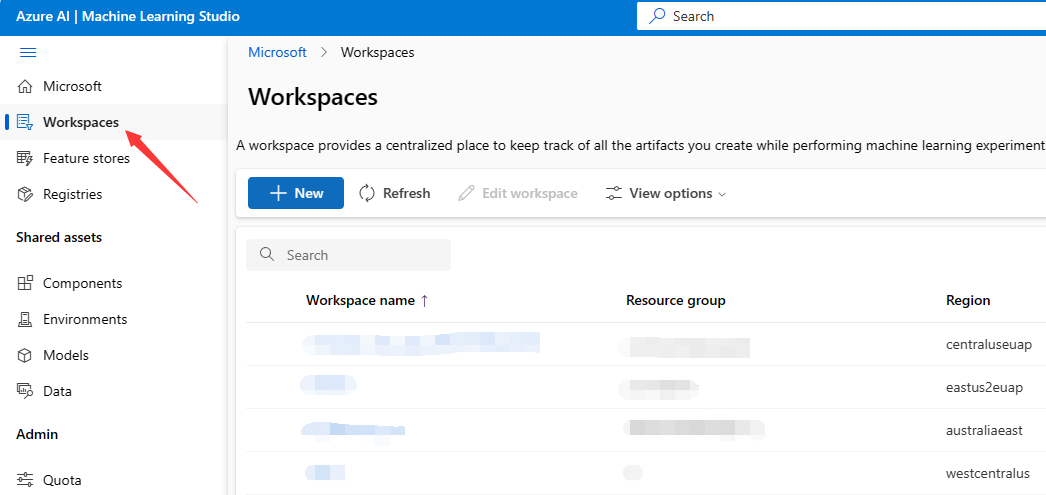
2. **Access Endpoints**: In the left-hand menu, find and click on "Endpoints".<br> 
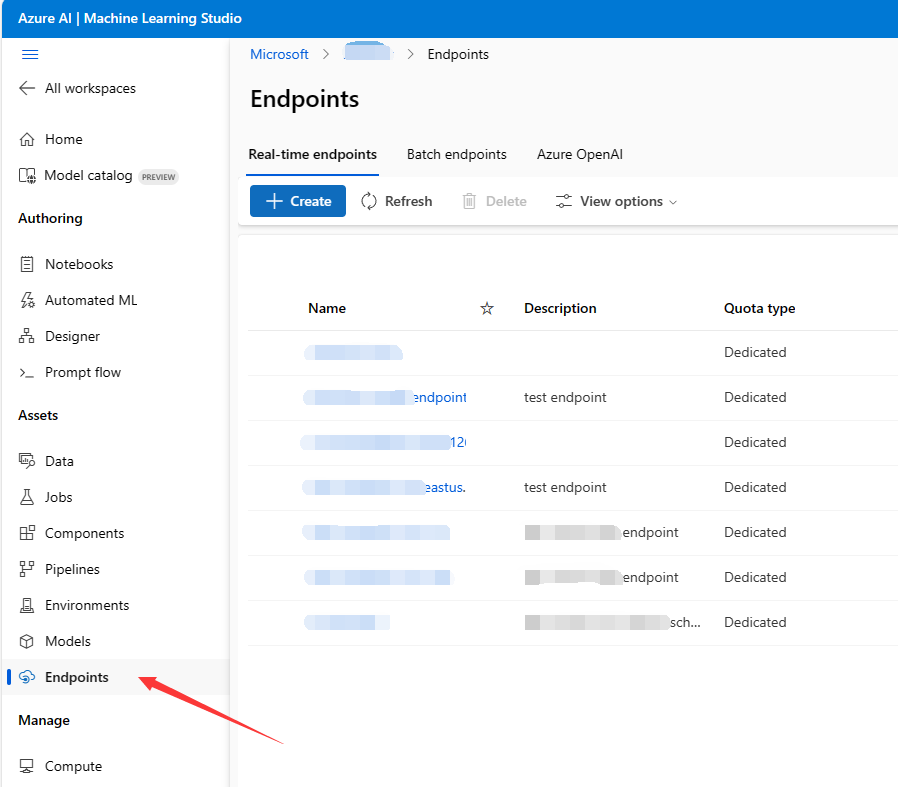
3. **Create Real-time Endpoint**: In the Endpoints page, click on "Real-time endpoints", then click on "+ Create".<br> 
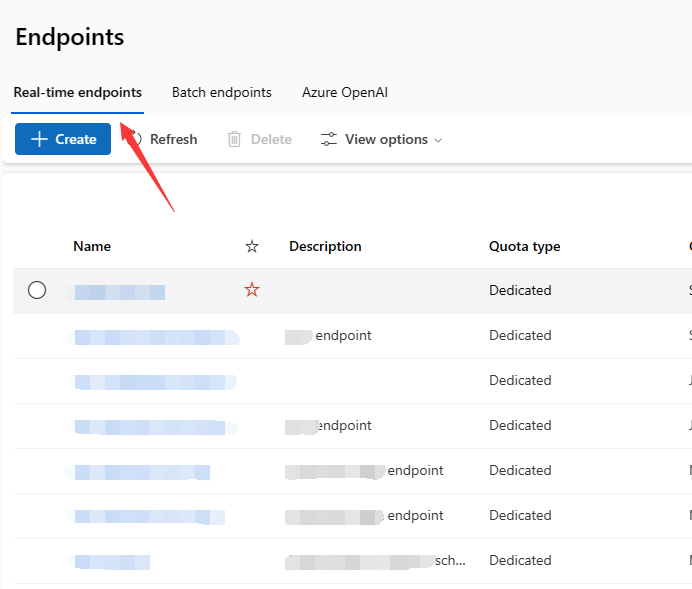
4. **Select a Model**: In the create endpoint form, you need to select a registered model. If you have not registered a model yet, you will need to do this in the "Models" page first.<br>
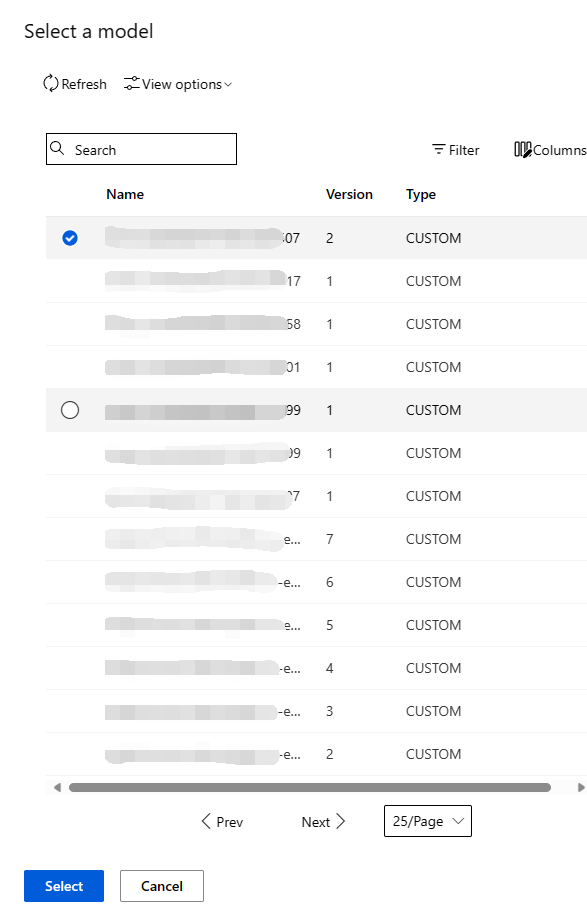
5. **Fill in the Endpoint Form**: In the form, you need to provide the following information:
   1. **Select Endpoint**: An endpoint is used to deploy and score your models. From the Azure Portal, navigate to your Azure Machine Learning workspace and select "Endpoints" from the sidebar.

   2. **Endpoint Details**:
      - **Endpoint Name**: Provide a unique identifier for your endpoint.
      - **Description**: Write a brief note about the endpoint's purpose.
      - **Compute Type**: Select the type of compute the endpoint will run on.
      - **Authentication Type**: Choose the type of authentication for the endpoint (Key-based or Token-based).
      - **Endpoint Tags**: Add tags to your endpoint for better organization and identification of your resources.<br>
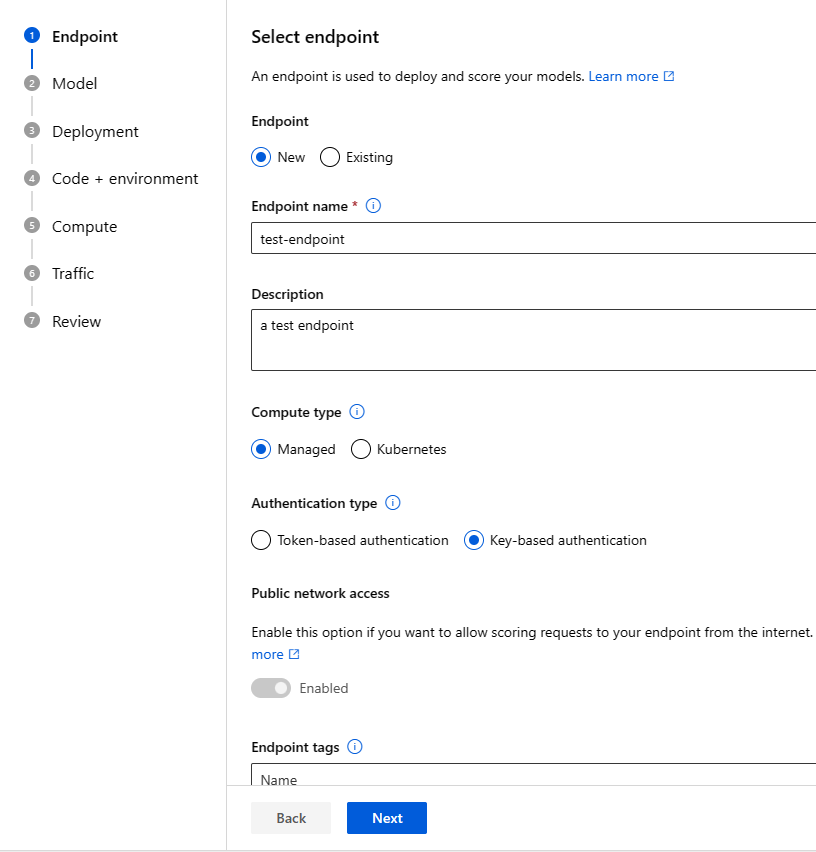
   3. **Deployment**:
      - **Deployment Name**: Provide a name for your deployment.
      - **Scoring Timeout (seconds)**: Specify the timeout for scoring in seconds.<br> 
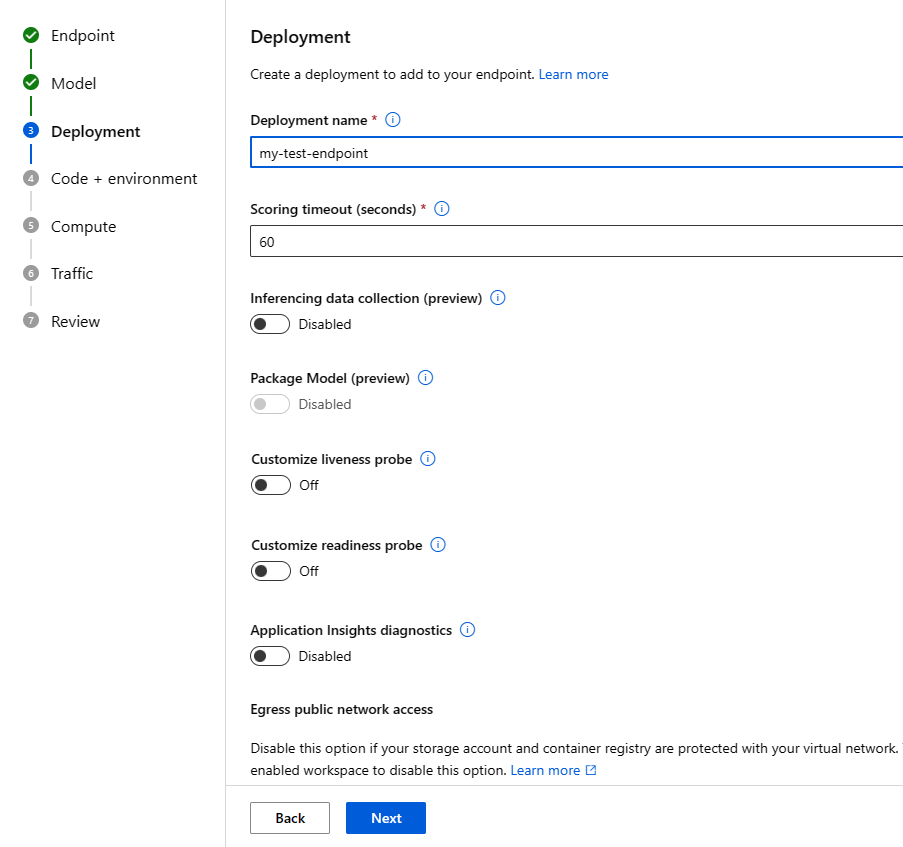
   4. **Code and Environment for Inferencing**: For the selected model, you need to provide at least one scoring Python script and an environment. 
      - **Select a Scoring Script for Inferencing**: Choose the Python script that will be used for scoring.
      - **Optional Script(s)**: If you have any additional scripts, add them here.
      - **Select an Environment for Inferencing**: Choose the environment that will be used for scoring.<br>
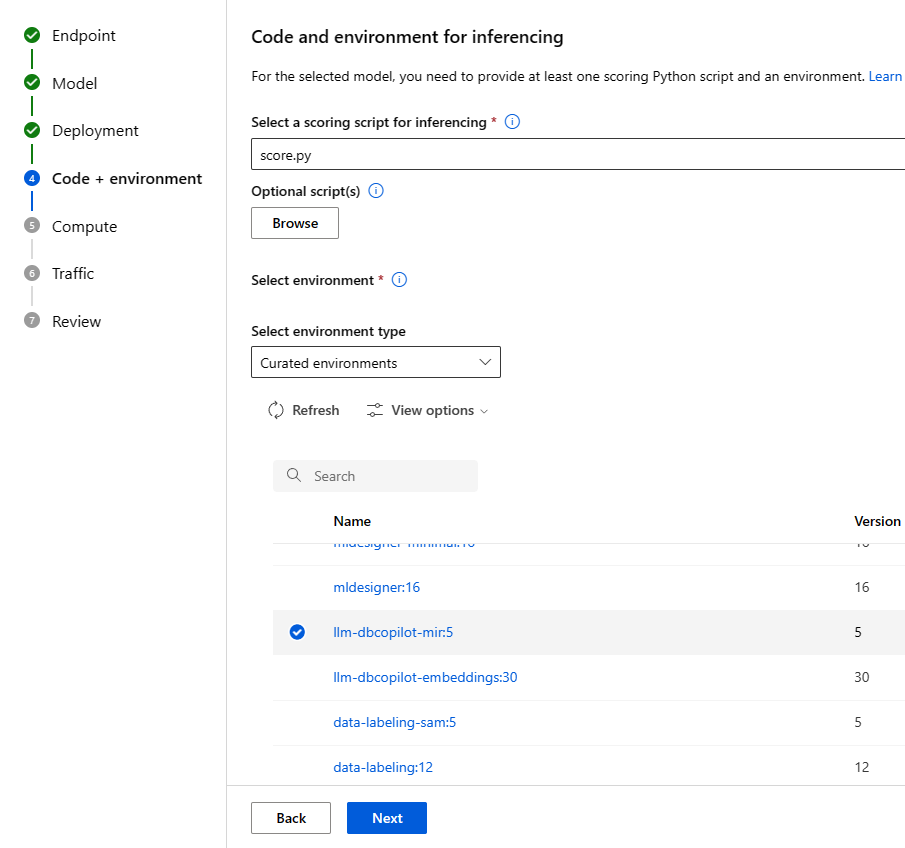
   5. **Compute**
      - **Virtual Machine**: Select the type of virtual machine. For example, "Standard_DS3_v2" which includes 4 Cores, 14 GB RAM, 28 GB Disk, and costs \$0.29/hr.
      - **Instance Count**: Specify the number of instances for your deployment.<br> 
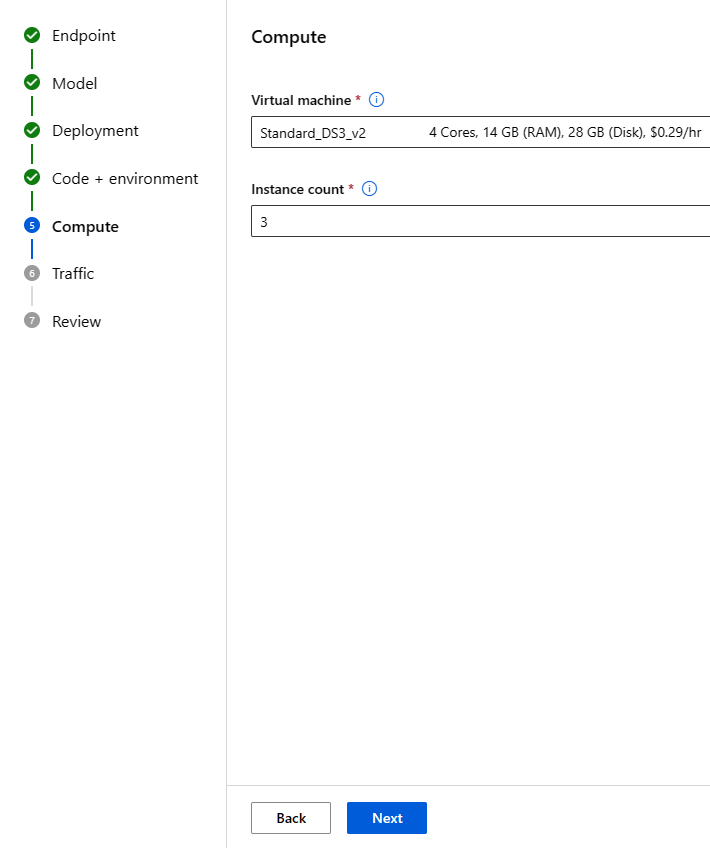
   6. **Live Traffic**: Ensure that the allocated live traffic between all deployments adds up to either 0% or 100%.<br>
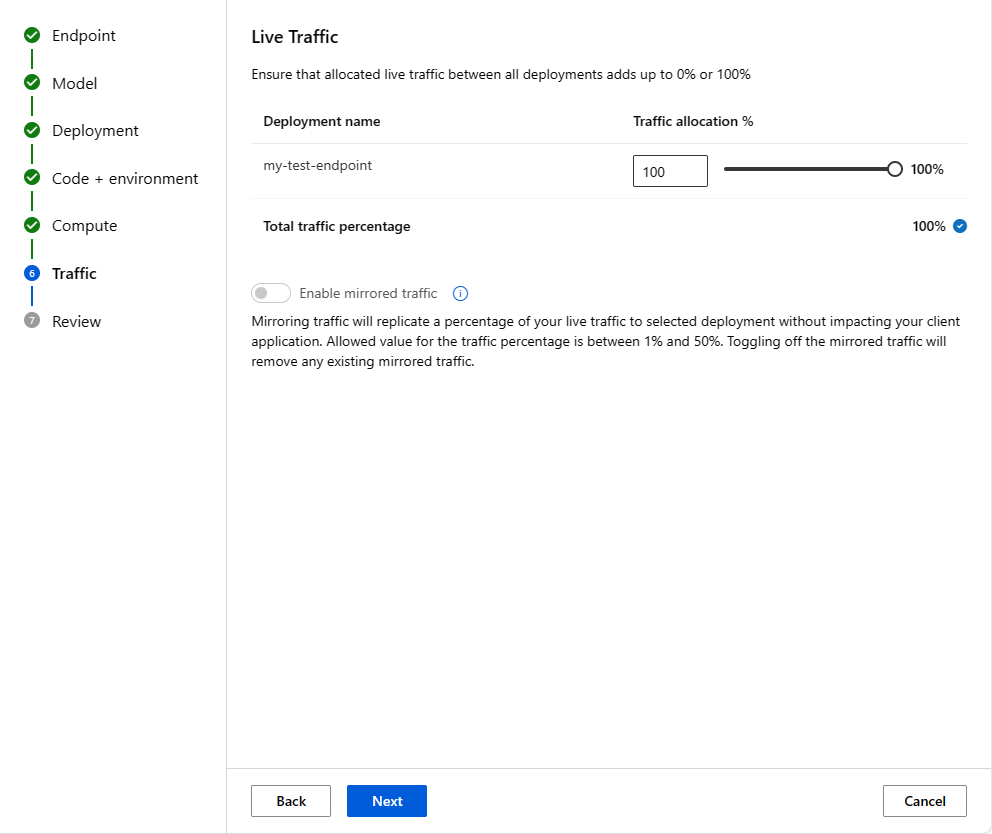

After filling in all the necessary information, click on the "Create" button. Azure ML will begin creating your endpoint, and you can monitor the progress on the Endpoints page.


In [ ]:
pip install azureml-sdk azureml-core

In [ ]:
from azureml.core import Workspace
from azureml.core import Model
from azureml.core import Environment
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice

# 'config.json' is a configuration file that contains the details about your Azure Machine Learning service workspace.
# It includes details like subscription id, resource group, and workspace name.
ws = Workspace.from_config(path="your_path/config.json")

# Model is a class representing a machine learning model.
# You need to specify the workspace and the name of the model you want to use.
model = Model(ws, "model_name")

# Environment is a class representing a software environment. It can include Python packages, environment variables, and software settings.
# You need to specify the workspace, the name and the version of the environment you want to use.
myenv = Environment.get(
    workspace=ws, name="environment_name", version="0environment_version"
)

# InferenceConfig is a class representing a configuration for model deployment.
# It includes an entry script (score.py) and an environment.
# 'score.py' is a Python script that is used to run the model for prediction.
# It includes two main functions: init() to initialize the model, and run() to run the model on input data and return a prediction.
inference_config = InferenceConfig(entry_script="your_path/score.py", environment=myenv)

# AciWebservice.deploy_configuration is a method to specify the deployment configuration like the number of cores and memory size for the Azure Container Instance.
aci_config = AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=1)

# Model.deploy is a method to deploy a model to a webservice.
# You need to specify the workspace, the name of the new endpoint, the model, the inference configuration, and the deployment configuration.
service = Model.deploy(ws, "new-endpoint-name", [model], inference_config, aci_config)

# service.wait_for_deployment(show_output=True) is a method to wait for the deployment to complete and show the output log.
service.wait_for_deployment(show_output=True)

Deploy to your Endpoint

The Components are published to a [Registry](https://learn.microsoft.com/azure/machine-learning/how-to-manage-registries?view=azureml-api-2&tabs=cli), `azureml`, which should have access to by default, it can be accessed from any Workspace.
In the below cell we get the Component Definitions from the `azureml` registry.

In [ ]:
ml_registry = MLClient(credential=credential, registry_name="azureml")

db_copilot_component = ml_registry.components.get(
    "llm_ingest_dbcopilot_faiss_e2e", label="latest"
)

print(db_copilot_component)

In [ ]:
@pipeline(
    name=f"test_db_copilot_e2e_pipeline_faiss_{component_version}",
    version=component_version,
)
def db_copilot_e2e_pipeline_faiss(
    aoai_connection: str,
    db_datastore: str,
    embeddings_model: str,
    chat_aoai_deployment_name: str,
    embedding_aoai_deployment_name: str,
    mir_environment: str,
    endpoint_name: str,
    sample_data: Input = None,
    deployment_name: str = "blue",
    selected_tables: str = None,
    max_sampling_rows: int = 3,
    tools: str = None,
):
    db_copilot_component(
        db_datastore=db_datastore,
        embeddings_model=embeddings_model,
        chat_aoai_deployment_name=chat_aoai_deployment_name,
        embedding_aoai_deployment_name=embedding_aoai_deployment_name,
        embedding_connection=aoai_connection,
        llm_connection=aoai_connection,
        sample_data=sample_data,
        endpoint_name=endpoint_name,
        deployment_name=deployment_name,
        mir_environment=mir_environment,
        selected_tables=selected_tables,
        max_sampling_rows=max_sampling_rows,
        tools=tools,
    )
    return {}

In [ ]:
datastore_name = "<test_db_datastore_name>"
aoai_embedding_model_name = "text-embedding-ada-002"
deployment_name = f"{deployment_name}-faiss"
mir_environment = (
    "azureml://registries/azureml/environments/llm-dbcopilot-mir/versions/"
)
endpoint_name = "dbcopilot-mir"
sample_data = Input(type="uri_folder", path=example_data.path)
pipeline_job = db_copilot_e2e_pipeline_faiss(
    aoai_connection=aoai_connection_id,
    db_datastore=f"azureml://datastores/{datastore_name}",
    embeddings_model=f"azure_open_ai://deployment/{aoai_embedding_deployment_name}/model/{aoai_completion_model_name}",
    chat_aoai_deployment_name=aoai_completion_deployment_name,
    embedding_aoai_deployment_name=aoai_embedding_deployment_name,
    mir_environment=mir_environment,
    endpoint_name=endpoint_name,
    sample_data=sample_data,
    deployment_name=deployment_name,
    selected_tables='["[dbo].[jobs]"]',
    max_sampling_rows=3,
    tools=["python"],
)

In [ ]:
running_pipeline_job = ml_client.jobs.create_or_update(
    pipeline_job, experiment_name="db_copilot_pipeline"
)
running_pipeline_job

In [ ]:
ml_client.jobs.stream(running_pipeline_job.name)